In [2]:
#@title Install libraries and restart kernel.
!pip3 install --upgrade -q google-cloud-aiplatform tensorflow tensorflow-hub
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.3/321.3 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 80.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 54.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 84.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 35.7 MB/s eta 0:00:00


{'status': 'ok', 'restart': True}

In [9]:
#@title Set project params.
from google.colab import auth

PROJECT_ID = "stellar-works-391900" #@param{type: 'string'}
REGION = "us-central1"  # @param {type: "string"}
BUCKET_NAME = f"{PROJECT_ID}_inception_model_20230718" #@param
BUCKET_URI = f"gs://{BUCKET_NAME}"

# https://cloud.google.com/storage/docs/gsutil/commands/iam#ch-examples.
# On commandline, run: gcloud auth login on commandline.
auth.authenticate_user()
!gcloud config set project {PROJECT_ID}
!gsutil mb -l $REGION $BUCKET_URI


Updated property [core/project].
Creating gs://stellar-works-391900_inception_model_20230718/...


In [ ]:
#@title Building the model: download and save to bucket pre-trained inception v3 model.
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from google.cloud import aiplatform

aiplatform.init(project=PROJECT_ID, location=REGION, staging_bucket=BUCKET_URI)

classifier_model = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"
classifier = tf.keras.Sequential([hub.KerasLayer(classifier_model)])
classifier.build([None, 224, 224, 3])
MODEL_DIR = f"{BUCKET_URI}/model"
# classifier.save(MODEL_DIR)
# !gsutil ls $MODEL_DIR

In [13]:
#@title Building the model: build a servable model with serving functions.
CONCRETE_INPUT = "numpy_inputs"


def _preprocess(bytes_input):
    decoded = tf.io.decode_jpeg(bytes_input, channels=3)
    decoded = tf.image.convert_image_dtype(decoded, tf.float32)
    resized = tf.image.resize(decoded, size=(224, 224))
    return resized


@tf.function(input_signature=[tf.TensorSpec([None], tf.string)])
def preprocess_fn(bytes_inputs):
    #decoded_images = tf.map_fn(
    #    _preprocess, bytes_inputs, dtype=tf.float32, back_prop=False
    #)
    decoded_images = tf.nest.map_structure(
        tf.stop_gradient,
        tf.map_fn(_preprocess, bytes_inputs, dtype=tf.float32))
    return {
        CONCRETE_INPUT: decoded_images
    }


@tf.function(input_signature=[tf.TensorSpec([None], tf.string)])
def serving_fn(bytes_inputs):
    images = preprocess_fn(bytes_inputs)
    prob = m_call(**images)
    return prob


m_call = tf.function(classifier.call).get_concrete_function(
    [tf.TensorSpec(shape=[None, 224, 224, 3], dtype=tf.float32, name=CONCRETE_INPUT)]
)

tf.saved_model.save(
    classifier,
    MODEL_DIR,
    signatures={
        "serving_default": serving_fn,
        "xai_preprocess": preprocess_fn,  # Required for XAI
        "xai_model": m_call,  # Required for XAI
    },
)

loaded = tf.saved_model.load(MODEL_DIR)
serving_input = list(
    loaded.signatures["serving_default"].structured_input_signature[1].keys()
)[0]
print("Serving function input:", serving_input)

Serving function input: bytes_inputs


In [15]:
!saved_model_cli show --dir $MODEL_DIR --all

2023-07-18 15:35:03.689862: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['bytes_inputs'] tensor_info:
        dtype: DT_STRING
        shape: (-1)
        name: serving_default_bytes_inputs:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['output_0'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 1001)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict

sig

In [16]:
#@title Deploying the model with explanations to Vertex AI.
XAI = "ig"  # [ shapley, ig, xrai ]

if XAI == "shapley":
    PARAMETERS = {"sampled_shapley_attribution": {"path_count": 10}}
elif XAI == "ig":
    PARAMETERS = {"integrated_gradients_attribution": {"step_count": 50}}
elif XAI == "xrai":
    PARAMETERS = {"xrai_attribution": {"step_count": 40}}
parameters = aiplatform.explain.ExplanationParameters(PARAMETERS)

MODEL_DISPLAY_NAME = "inception_v3_model_20230718_" + XAI
DEPLOY_IMAGE = "us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-11:latest"
model = aiplatform.Model.upload(
    display_name=MODEL_DISPLAY_NAME,
    artifact_uri=MODEL_DIR,
    serving_container_image_uri=DEPLOY_IMAGE,
    explanation_parameters=parameters,
) # you can specify parent_model to upload a new version of an existing model.

# Or you can do it via a nice step-by-step UI here (click "create"):
# https://console.cloud.google.com/vertex-ai/online-prediction/endpoints
# Then you can load it via:
# endpoint = aiplatform.Endpoint(
#    'projects/169980334830/locations/us-central1/endpoints/1531360212747812864')
DEPLOY_DISPLAY_NAME = MODEL_DISPLAY_NAME + "_deployed_endpoint"
DEPLOY_COMPUTE = "n1-standard-4"
endpoint = model.deploy(
    deployed_model_display_name=DEPLOY_DISPLAY_NAME,
    machine_type=DEPLOY_COMPUTE,
    accelerator_type=None,
    accelerator_count=0,
)

Creating Model


INFO:google.cloud.aiplatform.models:Creating Model


Create Model backing LRO: projects/169980334830/locations/us-central1/models/6703390342038683648/operations/6319437789242851328


INFO:google.cloud.aiplatform.models:Create Model backing LRO: projects/169980334830/locations/us-central1/models/6703390342038683648/operations/6319437789242851328


Model created. Resource name: projects/169980334830/locations/us-central1/models/6703390342038683648@1


INFO:google.cloud.aiplatform.models:Model created. Resource name: projects/169980334830/locations/us-central1/models/6703390342038683648@1


To use this Model in another session:


INFO:google.cloud.aiplatform.models:To use this Model in another session:


model = aiplatform.Model('projects/169980334830/locations/us-central1/models/6703390342038683648@1')


INFO:google.cloud.aiplatform.models:model = aiplatform.Model('projects/169980334830/locations/us-central1/models/6703390342038683648@1')


Creating Endpoint


INFO:google.cloud.aiplatform.models:Creating Endpoint


Create Endpoint backing LRO: projects/169980334830/locations/us-central1/endpoints/1531360212747812864/operations/3268811991652761600


INFO:google.cloud.aiplatform.models:Create Endpoint backing LRO: projects/169980334830/locations/us-central1/endpoints/1531360212747812864/operations/3268811991652761600


Endpoint created. Resource name: projects/169980334830/locations/us-central1/endpoints/1531360212747812864


INFO:google.cloud.aiplatform.models:Endpoint created. Resource name: projects/169980334830/locations/us-central1/endpoints/1531360212747812864


To use this Endpoint in another session:


INFO:google.cloud.aiplatform.models:To use this Endpoint in another session:


endpoint = aiplatform.Endpoint('projects/169980334830/locations/us-central1/endpoints/1531360212747812864')


INFO:google.cloud.aiplatform.models:endpoint = aiplatform.Endpoint('projects/169980334830/locations/us-central1/endpoints/1531360212747812864')


Deploying model to Endpoint : projects/169980334830/locations/us-central1/endpoints/1531360212747812864


INFO:google.cloud.aiplatform.models:Deploying model to Endpoint : projects/169980334830/locations/us-central1/endpoints/1531360212747812864


Deploy Endpoint model backing LRO: projects/169980334830/locations/us-central1/endpoints/1531360212747812864/operations/2854480825934675968


INFO:google.cloud.aiplatform.models:Deploy Endpoint model backing LRO: projects/169980334830/locations/us-central1/endpoints/1531360212747812864/operations/2854480825934675968


Endpoint model deployed. Resource name: projects/169980334830/locations/us-central1/endpoints/1531360212747812864


INFO:google.cloud.aiplatform.models:Endpoint model deployed. Resource name: projects/169980334830/locations/us-central1/endpoints/1531360212747812864


In [17]:
endpoint.gca_resource

name: "projects/169980334830/locations/us-central1/endpoints/1531360212747812864"
display_name: "inception_v3_model_20230718_ig_endpoint"
deployed_models {
  id: "3911853464417730560"
  model: "projects/169980334830/locations/us-central1/models/6703390342038683648"
  display_name: "inception_v3_model_20230718_ig_deployed_endpoint"
  create_time {
    seconds: 1689694961
    nanos: 173073000
  }
  dedicated_resources {
    machine_spec {
      machine_type: "n1-standard-4"
    }
    min_replica_count: 1
    max_replica_count: 1
  }
  explanation_spec {
    parameters {
      integrated_gradients_attribution {
        step_count: 50
      }
    }
    metadata {
    }
  }
  model_version_id: "1"
}
traffic_split {
  key: "3911853464417730560"
  value: 100
}
etag: "AMEw9yMJh2W9SWxkPgg-o12xYSfPs45mWgV3HIOpKCvuE6WppDRuY5Hp2A_D7Qo6Nwt1"
create_time {
  seconds: 1689694957
  nanos: 155021000
}
update_time {
  seconds: 1689695271
  nanos: 734247000
}

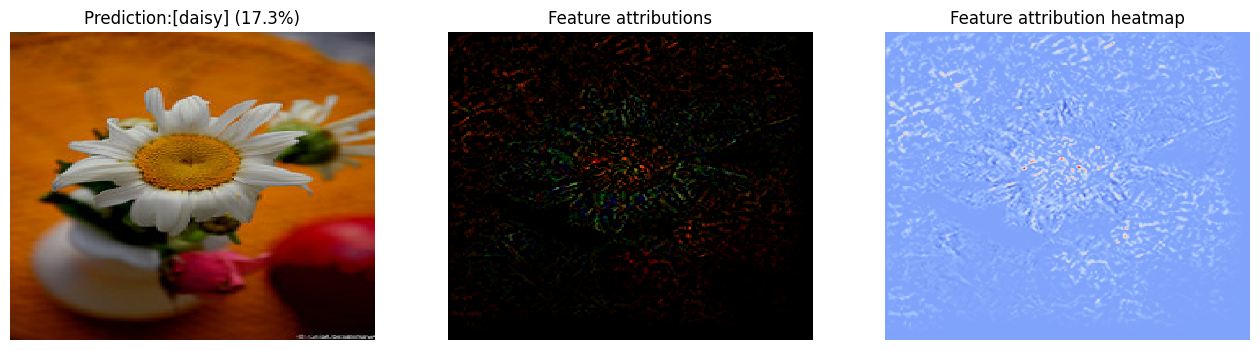

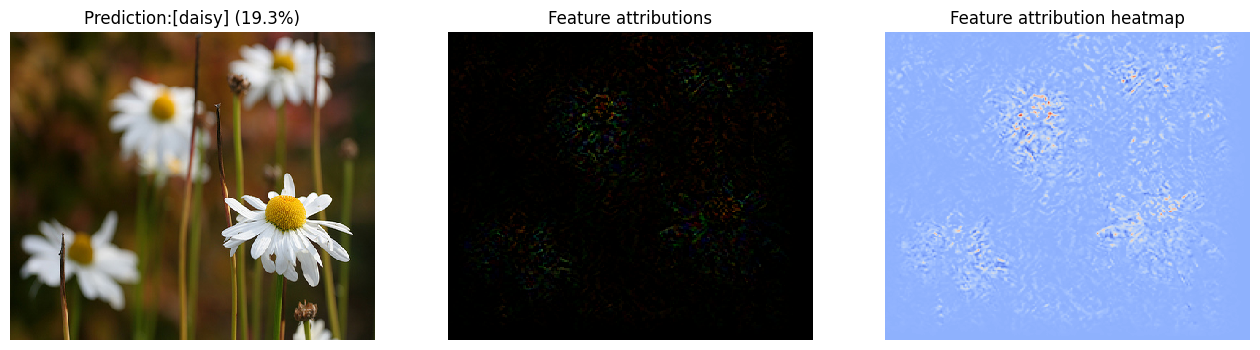

In [18]:
#@title Inference: flower photos, predict and explain via integrated-gradients (IG).
import base64
import io
import json
import pathlib
import sys
import PIL
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub


import matplotlib.image as mpimg
import matplotlib.pyplot as plt

data_dir = tf.keras.utils.get_file(
    "flower_photos",
    origin="https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz",
    untar=True,
)

data_dir = pathlib.Path(data_dir)
images_files = list(data_dir.glob("daisy/*"))

labels_path = tf.keras.utils.get_file(
    "ImageNetLabels.txt",
    "https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt",
)

imagenet_labels = np.array(open(labels_path).read().splitlines())


def encode_image_in_b64(image_file):
    bytes = tf.io.read_file(image_file)
    b64str = base64.b64encode(bytes.numpy()).decode("utf-8")
    return b64str


def decode_b64_image(b64_image_str):
    image = base64.b64decode(b64_image_str)
    image = io.BytesIO(image)
    image = mpimg.imread(image, format="JPG")
    return image


def decode_numpy_image(numpy_inputs):
    numpy_inputs_json = json.loads(str(numpy_inputs))
    image = np.array(numpy_inputs_json)
    return image


def show_explanation(encoded_image, prediction, feature_attributions):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))

    label_index = np.argmax(prediction)
    class_name = imagenet_labels[label_index]
    confidence_score = prediction[label_index]
    axs[0].set_title(
        "Prediction:[" + class_name + "] (" + str(round(confidence_score, 1)) + "%)"
    )
    original_image = decode_b64_image(encoded_image)
    axs[0].imshow(original_image, interpolation="nearest", aspect="auto")
    axs[0].axis("off")

    numpy_inputs = feature_attributions["numpy_inputs"]
    attribution_image = decode_numpy_image(numpy_inputs)
    axs[1].set_title("Feature attributions")
    axs[1].imshow(attribution_image, interpolation="nearest", aspect="auto")
    axs[1].axis("off")

    processed_image = attribution_image.max(axis=2)
    axs[2].imshow(processed_image, cmap="coolwarm", aspect="auto")
    axs[2].set_title("Feature attribution heatmap")
    axs[2].axis("off")


def encode_image_numpy(image_file):
    img = PIL.Image.open(image_file)
    img = img.resize((128, 128), PIL.Image.ANTIALIAS)
    img = np.array(img) / 255.0
    return img.tolist()

def show_explanation_numpy(original_image, prediction, feature_attributions):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))

    label_index = np.argmax(prediction)
    class_name = imagenet_labels[label_index]
    confidence_score = prediction[label_index]
    axs[0].set_title(
        "Prediction:[" + class_name + "] (" + str(round(confidence_score, 1)) + "%)"
    )
    axs[0].imshow(original_image, interpolation="nearest", aspect="auto")
    axs[0].axis("off")

    numpy_inputs = feature_attributions["keras_layer_1_input"]
    attribution_image = decode_numpy_image(numpy_inputs)
    axs[1].set_title("Feature attributions")
    axs[1].imshow(attribution_image, interpolation="nearest", aspect="auto")
    axs[1].axis("off")

    processed_image = attribution_image.max(axis=2)
    axs[2].imshow(processed_image, cmap="coolwarm", aspect="auto")
    axs[2].set_title("Feature attribution heatmap")
    axs[2].axis("off")


instances_list = [
    {
        serving_input: {
            "b64": encode_image_in_b64(str(images_files[i]))
        }
    }
    for i in [124, 500]
]

response = endpoint.explain(instances_list)

for i, instance in enumerate(instances_list):
    encoded_image = instance[serving_input]["b64"]
    prediction = response.predictions[i]
    explanation = response.explanations[i]
    feature_attributions = dict(explanation.attributions[0].feature_attributions)
    show_explanation(encoded_image, prediction, feature_attributions)


In [7]:
#@title Inference: batch prediction job.

# Connect to a new model via:
# model = aiplatform.Model(
#    'projects/169980334830/locations/us-central1/models/6703390342038683648@1')
gcs_input_uri = f"{BUCKET_URI}/test_images.json"

with tf.io.gfile.GFile(gcs_input_uri, "w") as f:
  for instance in instances_list:
    f.write(json.dumps(instance) + "\n")
JOB_DISPLAY_NAME = "inception_v3_job_batch_predict_20230718"
batch_predict_job = model.batch_predict(
    job_display_name=JOB_DISPLAY_NAME,
    gcs_source=gcs_input_uri,
    gcs_destination_prefix=BUCKET_URI,
    instances_format="jsonl",
    model_parameters=None,
    machine_type="n1-standard-4",
    generate_explanation=True,
)
batch_predict_job.output_info

Creating BatchPredictionJob


INFO:google.cloud.aiplatform.jobs:Creating BatchPredictionJob


BatchPredictionJob created. Resource name: projects/169980334830/locations/us-central1/batchPredictionJobs/4783694785707769856


INFO:google.cloud.aiplatform.jobs:BatchPredictionJob created. Resource name: projects/169980334830/locations/us-central1/batchPredictionJobs/4783694785707769856


To use this BatchPredictionJob in another session:


INFO:google.cloud.aiplatform.jobs:To use this BatchPredictionJob in another session:


bpj = aiplatform.BatchPredictionJob('projects/169980334830/locations/us-central1/batchPredictionJobs/4783694785707769856')


INFO:google.cloud.aiplatform.jobs:bpj = aiplatform.BatchPredictionJob('projects/169980334830/locations/us-central1/batchPredictionJobs/4783694785707769856')


View Batch Prediction Job:
https://console.cloud.google.com/ai/platform/locations/us-central1/batch-predictions/4783694785707769856?project=169980334830


INFO:google.cloud.aiplatform.jobs:View Batch Prediction Job:
https://console.cloud.google.com/ai/platform/locations/us-central1/batch-predictions/4783694785707769856?project=169980334830


BatchPredictionJob projects/169980334830/locations/us-central1/batchPredictionJobs/4783694785707769856 current state:
JobState.JOB_STATE_RUNNING


INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/169980334830/locations/us-central1/batchPredictionJobs/4783694785707769856 current state:
JobState.JOB_STATE_RUNNING


BatchPredictionJob projects/169980334830/locations/us-central1/batchPredictionJobs/4783694785707769856 current state:
JobState.JOB_STATE_RUNNING


INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/169980334830/locations/us-central1/batchPredictionJobs/4783694785707769856 current state:
JobState.JOB_STATE_RUNNING


BatchPredictionJob projects/169980334830/locations/us-central1/batchPredictionJobs/4783694785707769856 current state:
JobState.JOB_STATE_RUNNING


INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/169980334830/locations/us-central1/batchPredictionJobs/4783694785707769856 current state:
JobState.JOB_STATE_RUNNING


BatchPredictionJob projects/169980334830/locations/us-central1/batchPredictionJobs/4783694785707769856 current state:
JobState.JOB_STATE_RUNNING


INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/169980334830/locations/us-central1/batchPredictionJobs/4783694785707769856 current state:
JobState.JOB_STATE_RUNNING


BatchPredictionJob projects/169980334830/locations/us-central1/batchPredictionJobs/4783694785707769856 current state:
JobState.JOB_STATE_RUNNING


INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/169980334830/locations/us-central1/batchPredictionJobs/4783694785707769856 current state:
JobState.JOB_STATE_RUNNING


BatchPredictionJob projects/169980334830/locations/us-central1/batchPredictionJobs/4783694785707769856 current state:
JobState.JOB_STATE_RUNNING


INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/169980334830/locations/us-central1/batchPredictionJobs/4783694785707769856 current state:
JobState.JOB_STATE_RUNNING


BatchPredictionJob projects/169980334830/locations/us-central1/batchPredictionJobs/4783694785707769856 current state:
JobState.JOB_STATE_RUNNING


INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/169980334830/locations/us-central1/batchPredictionJobs/4783694785707769856 current state:
JobState.JOB_STATE_RUNNING


BatchPredictionJob projects/169980334830/locations/us-central1/batchPredictionJobs/4783694785707769856 current state:
JobState.JOB_STATE_RUNNING


INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/169980334830/locations/us-central1/batchPredictionJobs/4783694785707769856 current state:
JobState.JOB_STATE_RUNNING


BatchPredictionJob projects/169980334830/locations/us-central1/batchPredictionJobs/4783694785707769856 current state:
JobState.JOB_STATE_SUCCEEDED


INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/169980334830/locations/us-central1/batchPredictionJobs/4783694785707769856 current state:
JobState.JOB_STATE_SUCCEEDED


BatchPredictionJob run completed. Resource name: projects/169980334830/locations/us-central1/batchPredictionJobs/4783694785707769856


INFO:google.cloud.aiplatform.jobs:BatchPredictionJob run completed. Resource name: projects/169980334830/locations/us-central1/batchPredictionJobs/4783694785707769856


gcs_output_directory: "gs://stellar-works-391900_inception_model_20230717/prediction-inception_v3_model_unique-2023_07_18T07_40_55_548Z"

In [ ]:
#@title Cleanup: (warning) deletes the endpoint, model and storage bucket.
import os

endpoint.undeploy_all()
endpoint.delete()
model.delete()
batch_predict_job.delete()
!gsutil -m rm -r $BUCKET_URI